In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tfcvnn as cvnn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from scipy.io import loadmat

data = loadmat('C:/Users/saucourt/Coding/tensorflow_cvnn/synth_dset_step_lambda=1064nm_Nmodes=269_degen=True_len=5000_mirr=64_exp_noise_1_of_1.mat')

In [6]:
data.keys()
print(data['intens'].shape)
print(data['phase_maps'].shape)
print(data['macropixels_energy'].shape)

(64, 64, 5000)
(8, 8, 5000)
(8, 8)


In [19]:
# Y = np.sqrt(np.rollaxis(data['intens'], -1, 0))
Y = np.rollaxis(data['fields'], -1, 0)
X = np.rollaxis(data['phase_maps'], -1, 0)
Z = np.sqrt(np.rollaxis(data['intens_transf'], -1, 0))
X = np.exp(1j * X) * np.expand_dims(np.sqrt(data['macropixels_energy']), 0)

N = X.shape[0]
X = np.reshape(X, (N, -1))
Y = np.reshape(Y, (N, -1))
Z = np.reshape(Z, (N, -1))
n = X.shape[-1]
m = Y.shape[-1]
npx = int(np.sqrt(m))

gamma = 5
X = X[int(gamma*n):, :]
Y = Y[int(gamma*n):, :]
Z = Z[int(gamma*n):, :]

print(Y.shape, Y.dtype)
print(X.shape, X.dtype)

(4680, 4096) complex128
(4680, 64) complex128


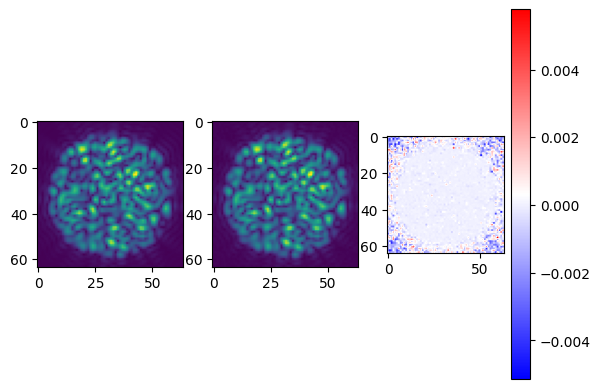

In [27]:
from waveoptics.propag.tf import fft_2d

yp = np.pad(Y[0, ...].reshape(n, n), pad_width=((n//2, n//2), (n//2, n//2)))
zp = fft_2d(yp).numpy()
zp = zp[n//2:-n//2, n//2:-n//2]
z = Z[0, ...].reshape(n, n)


plt.figure()

plt.subplot(1, 3, 1)
plt.imshow(np.abs(zp))

plt.subplot(1, 3, 2)
plt.imshow(np.abs(z))

plt.subplot(1, 3, 3)
plt.imshow(np.abs(zp) - np.abs(z), cmap='bwr')
plt.colorbar()

In [8]:
# N = 3000

# TM = data['reshaped_transfer_matrix']
# m, n = TM.shape

# TM = TM * np.expand_dims(np.exp(-1j * np.angle(TM[0, :])), axis=0)
# X = np.random.rand(N, n) * np.exp(1j * 2 * np.pi * np.random.rand(N, n))
# Y = (TM @ X.T).T

# print(Y.shape)
# print(X.shape)

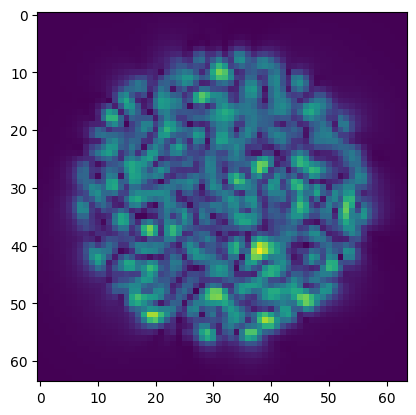

In [9]:
plt.imshow(np.abs(Y[0, ...]).reshape(npx, npx))

In [10]:
# Example usage: Build a simple model with the custom complex dense layer
train_complex = False
activation = cvnn.activations.ComplexModLeakyReLU
layer = cvnn.layers.ComplexDense


inputs = tf.keras.Input(shape=(n,), dtype=tf.complex64)
# x = layer(20)(inputs)
# x = activation()(x)
# x = layer(1000)(inputs)
# x = activation()(x)
# # x = ComplexDense(100)(x)
outputs = layer(m)(inputs)
outputs = activation()(outputs)

# outputs = ComplexDense(m)(inputs)
if train_complex:
    outputs = tf.abs(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 complex_dense (ComplexDense  (None, 4096)             532480    
 )                                                               
                                                                 
 complex_mod_leaky_re_lu (Co  (None, 4096)             0         
 mplexModLeakyReLU)                                              
                                                                 
Total params: 532,480
Trainable params: 532,480
Non-trainable params: 0
_________________________________________________________________


In [11]:
x_tf = tf.cast(tf.convert_to_tensor(X), tf.complex64)
y_tf = tf.cast(tf.convert_to_tensor(Y), tf.complex64)
batch_size = 32
validation_split = 0.2

num_samples = x_tf.shape[0]
num_val_samples = int(validation_split * num_samples)

# Shuffle and split the data into training and validation sets
dataset = tf.data.Dataset.from_tensor_slices((x_tf, tf.abs(y_tf) if train_complex else y_tf))
dataset = dataset.shuffle(buffer_size=num_samples)

# Create training and validation datasets
train_dataset = dataset.skip(num_val_samples).batch(batch_size)
val_dataset = dataset.take(num_val_samples).batch(batch_size)

# Compile the model with a complex loss function
reduce_lr_callback_params = dict(monitor='val_loss', factor=0.3, patience=10, min_lr=1e-6, cooldown=2, min_delta=0.1, verbose=1,)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(**reduce_lr_callback_params)

adam_params = dict(learning_rate=1e-3, beta_1=0.9)
optimizer = tf.keras.optimizers.Adam(**adam_params)

model.compile(optimizer=optimizer, loss='mse')

# Train the model
model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[reduce_lr_callback])


Epoch 1/10
117/117 [==============================] - 2s 14ms/step - loss: 0.0085 - val_loss: 1.5036e-05 - lr: 0.0010
Epoch 2/10
117/117 [==============================] - 2s 14ms/step - loss: 1.7346e-06 - val_loss: 1.0919e-09 - lr: 0.0010
Epoch 3/10
117/117 [==============================] - 2s 15ms/step - loss: 1.1682e-10 - val_loss: 2.7299e-14 - lr: 0.0010
Epoch 4/10
117/117 [==============================] - 2s 13ms/step - loss: 3.2536e-15 - val_loss: 6.1343e-16 - lr: 0.0010
Epoch 5/10
117/117 [==============================] - 2s 16ms/step - loss: 5.8640e-16 - val_loss: 5.4828e-16 - lr: 0.0010
Epoch 6/10
117/117 [==============================] - 2s 13ms/step - loss: 5.2936e-16 - val_loss: 5.0081e-16 - lr: 0.0010
Epoch 7/10
117/117 [==============================] - 2s 15ms/step - loss: 4.8616e-16 - val_loss: 4.6268e-16 - lr: 0.0010
Epoch 8/10
117/117 [==============================] - 2s 14ms/step - loss: 4.5275e-16 - val_loss: 4.3527e-16 - lr: 0.0010
Epoch 9/10
117/117 [========

In [12]:
def _tf_get_predictions_from_batched_dataset(model, dataset,):
    preds, trues = [], []
    for x, y in dataset:
        preds.append(model.predict(x, verbose = 0))   # Predict on the current batch
        trues.append(y.numpy())          # Collect the true labels of the current batch
    # Now concatenate them if necessary
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    return preds, trues

preds, trues = _tf_get_predictions_from_batched_dataset(model, val_dataset)

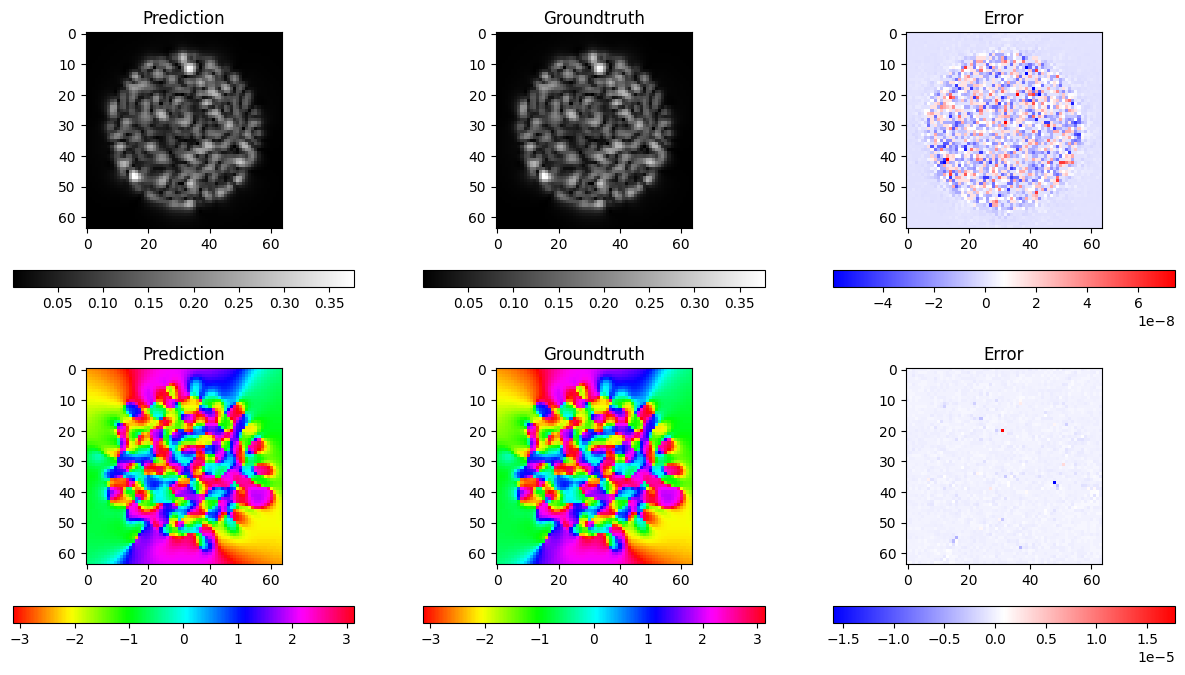

In [13]:
idx = np.random.randint(preds.shape[0])

plt.figure(figsize=(15, 8))
plt.subplot(2, 3, 1)
plt.imshow(np.abs(preds[idx, ...]).reshape(npx, npx), cmap='gray')
plt.title('Prediction')
plt.colorbar(location='bottom')

plt.subplot(2, 3, 2)
plt.imshow(np.abs(trues[idx, ...]).reshape(npx, npx), cmap='gray')
plt.title('Groundtruth')
plt.colorbar(location='bottom')

plt.subplot(2, 3, 3)
plt.imshow(np.abs(preds[idx, ...]).reshape(npx, npx) - np.abs(trues[idx, ...]).reshape(npx, npx), cmap='bwr')
plt.title('Error')
plt.colorbar(location='bottom')

plt.subplot(2, 3, 4)
plt.imshow(np.angle(preds[idx, ...]).reshape(npx, npx), cmap='hsv')
plt.title('Prediction')
plt.colorbar(location='bottom')

plt.subplot(2, 3, 5)
plt.imshow(np.angle(trues[idx, ...]).reshape(npx, npx), cmap='hsv')
plt.title('Groundtruth')
plt.colorbar(location='bottom')

plt.subplot(2, 3, 6)
plt.imshow(np.angle(preds[idx, ...]).reshape(npx, npx) - np.angle(trues[idx, ...]).reshape(npx, npx), cmap='bwr')
plt.title('Error')
plt.colorbar(location='bottom')